# **TP Advanced Game Theory**
Done By: Raneem Madani, Ikhlas Enaieh and Zeidan Braik

---



# Project Overview:
In this proejct we are solving the supply-demand equilibrium in the electricity
system as France will be moving to more electricaly operated cars so this mean a more demand has to be satisfied for this regard. 

we have the unit commitment problem: $$\text{minimize}\sum_{i = 1}^{I}\sum_{t = 1}^{48} \alpha_ip_i(t)$$

With satisfying french demand and production unit constraint. What we understand from this problem is that france want to minimize the cost of energy production over the different assets BUT insuring availability of the demand.

This is a hard problem to be solved a more flexible approach will be applied. we will assume that the electrical vehicles are smartly charging in a way that minimizes the CO2 emissions resulting from producing energy from the different assets to satisfy a demand in a pecific slot. 

So a function that computes the emission resulted from a specific load (demand) has been defined at every time slot (we consider a day divided to half hours time slots = 48 which is easier for modeling and interpretations rather than dealing with a continuous interval) $$\forall \ell(t) \in \left[ 0,\sum_{i = 1}^I P_i \right], f^{CO2}(\ell(t)) = \sum_{i = 0}^{I-1}(CO2_{i+1} - CO2_i) \times \left[  \ell(t) - \hat{P}_i \right]^+ $$ with $\hat{P_i}$ to be the cumulative production unit of each asset (The way the array $P_i$ was obtained below is as mentioned in the report) and this will make our objective function looking like: $$\text{minimize}_{(\ell^{EV}_j(t))_{t = 1 , ....., 48}} \sum_{t = 1}^{48} f^{CO2}\left(\tilde{\ell}^{NF}(t) + \sum_{j' \neq j}\ell^{EV}_{j'}(t) + \ell^{EV}_j(t) \right)$$

$$\text{s.t.}$$ $$0 \; \leq \; \ell^{EV}_j(t) \; \leq 7\;  \; \forall t \in \{ a_j+1,.....,d_j-1 \} \; \;  \text{and} \; \; \ell^{EV}_j(t)=0 \; \; \text{otherwise} $$$$\sum_{t = a_j+1}^{d_j-1} \ell_j^{EV}(t) = \dfrac{e_j}{\delta}$$
we point out that most of the work that will be presented maily focuses on extracting the nonflexible load array $\tilde{\ell}^{NF}$(demand forcasted for all aspects except electricity dedicated for electrical vehilces) and it is the same for all the cars in a specific day and making it a parameter to find the best flexible array $\ell_j^{EV}$ for each car via smart charging with three methods that will be presented below:

**Objective Function Interpretation:**
 (flexible and non-flexible are powers in MW for each time slot t and the output of the CO2 function is in tCO2eq/h), this objective tries to minimize the load of the overall energy (all aspects and flexible load of each car) at each time slot so by charging smartly in the slots with lower load we obtain lowest possible Co2 emmission with keeping in mind a car can't be charged with energy greater than 7 in a time slot and the time slots not corresponding to charging should be zero and the sum of load over all time slots times your timeslot period shoud give you the energy.

# Importing Usefull Libraries

In [3]:
import pandas as pd  # TO Deal with Dataframes
import matplotlib.pyplot as plt # To perform the plots 
import numpy as np # to deal with matricies and norms
from dateutil.relativedelta import relativedelta
from pandas.core.arrays.datetimelike import timedelta  # importing the library we will use to convert 
#time slots to hours (i.e. 36 = 18:00:00)
from datetime import datetime , timedelta #datetime: converts date from string format to datetime format in python)
from numpy.linalg import norm # to use the norm for the stropping criteria in our BRD 

# Import the DataFrames

## Dataframe 1 "The EV_scenarios (ID , Energy , Arrival , Departure)

Reading the Dataset EV Scenarios.

Gives Data from ===> 01/01/2019 to 31/12/2019 <==== for the arrival and departure time for each car of the 10 cars that we have and the energy they need for the next day.

In [4]:
data2019 = pd.read_csv("ev_scenarios.csv",sep = ';')

Convert the values for the day column to datetime format and convert the timeslot number for the arrival and departure to their respective datetime format  For the sake of simplicity and following the convention that a car don't charge as soon as it arrives from now we will shift the time slots to the next one to have values of when exactly a car will charge and for departure we switch to the previous time slot as a car will stop charging in the slot prior to departure.

In [5]:
# The below menstioned code was done with the help of Prof. Olivier
data2019['day'] = data2019['day'].apply(lambda x: datetime.strptime(x,'%d/%m/%Y')) 
'''
 apply: when axis 1 works vertically I mean on rows and lambda is a function that assign a variable to a specific
  operation, strptime: to convert time from string to datetime while paying attention to format and order.
  '''
data2019['arr_time'] = data2019.apply(lambda row: row['day'] + timedelta(hours = (row['time_slot_arr']+1)*0.5),axis = 1) 
'''
# 0.5 stands for the half hour timeslots we concatenated the date with the hour
# Important! here we put (row['time_slot_arr']+1) for the sake of simplicity for 
the upcoming steps and to accept the convention that the care don't directly charge as soon as it arrives
'''
data2019['dep_time'] = data2019.apply(lambda row: row['day'] + timedelta(hours = (row['time_slot_dep']-1)*0.5) + timedelta(days = 1),axis = 1) 
'''
 # 0.5 stands for the half hour timeslots we concatenated the date with the hour
# Important! here we put (row['time_slot_dep']-1)*0.5) for the sake of simplicity for the upcoming 
steps and to accept the convention that the care don't directly disconnect as soon as it departs
'''
data2019.head(5)


,day,ev_id,time_slot_arr,time_slot_dep,energy_need (kWh),arr_time,dep_time
0,2019-01-01,1,36,14,5.0,2019-01-01 18:30:00,2019-01-02 06:30:00
1,2019-01-01,2,39,16,5.9,2019-01-01 20:00:00,2019-01-02 07:30:00
2,2019-01-01,3,37,15,5.0,2019-01-01 19:00:00,2019-01-02 07:00:00
3,2019-01-01,4,39,14,9.9,2019-01-01 20:00:00,2019-01-02 06:30:00
4,2019-01-01,5,35,16,5.0,2019-01-01 18:00:00,2019-01-02 07:30:00


We use the same dataframe for 2020 profiles for this regard a switch in the year took action

In [6]:
data2020 = pd.read_csv("ev_scenarios.csv",sep = ';')
data2020['day'] = data2020['day'].apply(lambda x: datetime.strptime(x,'%d/%m/%Y')+relativedelta(years=1)) 
# The relativedelta is to add one year for your datetime.year
data2020['arr_time'] = data2020.apply(lambda row: row['day'] + timedelta(hours = (row['time_slot_arr']+1)*0.5),axis = 1) 
data2020['dep_time'] = data2020.apply(lambda row: row['day'] + timedelta(hours = (row['time_slot_dep']-1)*0.5) + timedelta(days = 1),axis = 1)  
data2020.head(5)

,day,ev_id,time_slot_arr,time_slot_dep,energy_need (kWh),arr_time,dep_time
0,2020-01-01,1,36,14,5.0,2020-01-01 18:30:00,2020-01-02 06:30:00
1,2020-01-01,2,39,16,5.9,2020-01-01 20:00:00,2020-01-02 07:30:00
2,2020-01-01,3,37,15,5.0,2020-01-01 19:00:00,2020-01-02 07:00:00
3,2020-01-01,4,39,14,9.9,2020-01-01 20:00:00,2020-01-02 06:30:00
4,2020-01-01,5,35,16,5.0,2020-01-01 18:00:00,2020-01-02 07:30:00


## Dataframe 2 ECO2mix profiles (Forecast for seasons per year)

Read the ECO2MIX datframe for the year 2019 and 2020 at both seasons winter January and Summer June to perform some comparisons with both seasons and years.

These two datasets provide Data about Consumption, forecast day and forecast hour and a well detailed explanation of the energy consumption from every asset according to each time slot in (MW).

In [7]:
summer2019 = pd.read_csv('eCO2mix_RTE_Annuel-Definitif_2019_summer.csv', sep = ';')   # dataset corresponding to timeslots details over june of 2019
winter2019 = pd.read_csv('eCO2mix_RTE_Annuel-Definitif_2019_winter.csv', sep = ';')   # dataset corresponding to timeslots details over January of 2019

summer2020 = pd.read_csv('eCO2mix_RTE_Annuel-Definitif_2020_summer.csv', sep = ';')   # dataset corresponding to timeslots details over june of 2020
winter2020 = pd.read_csv('eCO2mix_RTE_Annuel-Definitif_2020_winter.csv', sep = ';')   # dataset corresponding to timeslots details over January of 2020

Convert Text to datetime

In [8]:
# The below menstioned code was done with the help of Prof. Olivier
summer2019['date'] = summer2019['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
winter2019['date'] = winter2019['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
winter2020['date'] = winter2020['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
summer2020['date'] = summer2020['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
summer2020.tail()

,date,consumption,forecast_day-1,forecast_hour-1,fuel,coal,gas,nuclear,wind,solar,hydro_pumping,bioenergy,co2_rate
1435,2020-06-30 21:30:00,44188.0,42700.0,43900.0,68.0,11.0,3823.0,26678.0,2621.0,62.0,-16.0,1061.0,39.0
1436,2020-06-30 22:00:00,43907.0,42300.0,43600.0,66.0,11.0,3688.0,26651.0,2513.0,12.0,-16.0,1065.0,38.0
1437,2020-06-30 22:30:00,45656.0,44600.0,45900.0,67.0,10.0,3707.0,26664.0,2487.0,8.0,-16.0,1060.0,39.0
1438,2020-06-30 23:00:00,47831.0,47300.0,48700.0,66.0,10.0,3814.0,26905.0,2673.0,5.0,-15.0,1071.0,38.0
1439,2020-06-30 23:30:00,47006.0,46600.0,47700.0,67.0,10.0,3718.0,26769.0,2951.0,6.0,-16.0,1068.0,38.0


# Define Functions to extract Parameters:

Four Main functions were Defined as follows: 


*   arrival_time to retun the exact date and timeslot the care starts charging overnight.
*   Daparture_time to return the exact date and time slot in which is disconnected from charger.
* Energy_need to return the amount of energy a car require to perform for the next day.

Note: these Functions require two parameters the date and the ID

* Non_Flexible_Load returns an array of respective forcast - day values corresponding to time slots in which the car will be charging.

This array stands for $\ell^{NF}_j$ which is the load (Demand) in MW forcasted to be required and satisfied for each timeslot and it is the nonflexible

Note: this functions needs the following parameters: the date, car ID) and two optional parameters for a desired arrival and departure time slots (these two parameters helpful for solving the problem for all cars).

One last function was defined to obtain a full description for each ID in a specific date.


In [9]:
def Non_Flexible_Load_Description( date, id):
  data2 = summer2020 # we just initialize
  data1 = data2020 # initialize also to prevent possible errors
  if datetime.strptime(date,'%Y/%m/%d').year == 2019:  # if you are in the specific year
    if datetime.strptime(date,'%Y/%m/%d').month == 1:  # you are in month
      data2 = winter2019 
      data1 = data2019
    elif datetime.strptime(date,'%Y/%m/%d').month == 6:
      data2 = summer2019 
      data1 = data2019 
    else:
      return('No available information for this month!!!! choose only 1 or 6')
    row = data1.loc[(data1['day'] == datetime.strptime(date,'%Y/%m/%d'))].loc[(data1['ev_id'] == id)]
     # get a one row dataframe containing these two parameters
    row_number = row.index[0] # get the index
# no we have the index so we can get arrival and departure time slots
    start_ev = data1['arr_time'][row_number] # Select the arrival time of EV j at day d
    end_ev = data1['dep_time'][row_number]  # Select the Departure time of EV j at day d
    print('Arrival time for the Electrical Vehicle {} on {} is:          {}'.format(id , date , start_ev))
    print('Departure time of the electrical Vehicle {} on {} is:      {}'.format(id , date , end_ev))
#to get the nonflexible load obtain a smaller dataset
    index1 = data2[data2['date'] == start_ev].index[0] # get the index in forcast dataset for arrival time
    index2 = data2[data2['date'] == end_ev].index[0] # same for departure time 
    one_EV_data =  data2[index1:index2]  # get the time slots we are interested in
    one_EV_data = one_EV_data.reset_index(drop=True) # reset index (not needed btw)

    energy = data1['energy_need (kWh)'][row_number]
    print('The amount of energy in KWh vehicle {} needs in {} is:         {}'.format(id , date, energy))

    nonflexible_load = np.array(one_EV_data['forecast_day-1'])
    print('The non-flexible load array is:               {}'.format(nonflexible_load))
    non_flexible_length = len(nonflexible_load)
    print('The Length of the non-flexible load array is:           {}'.format(non_flexible_length))
    
  elif datetime.strptime(date,'%Y/%m/%d').year == 2020: # same for the other year 
# we couldn't integrate a code putting it all under same condition
    if datetime.strptime(date,'%Y/%m/%d').month == 1:
      data2 = winter2020
      data1 = data2020
    elif datetime.strptime(date,'%Y/%m/%d').month == 6:
      data2 = summer2020
      data1 = data2020
    else:
      return('No available information for this month!!!! choose only 1 or 6')

    row = data1.loc[(data1['day'] == datetime.strptime(date,'%Y/%m/%d'))].loc[(data1['ev_id'] == id)] # get a row dataframe containing these two parameters
    row_number = row.index[0] # get the index

    start_ev = data1['arr_time'][row_number] # Select the arrival time of EV j at day d
    end_ev = data1['dep_time'][row_number]  # Select the Departure time of EV j at day d
    print('Arrival time for the Electrical Vehicle {} on {} is:          {}'.format(id , date , start_ev))
    print('Departure time of the electrical Vehicle {} on {} is:      {}'.format(id , date , end_ev))

    index1 = data2[data2['date'] == start_ev].index[0] # get the index in forcast dataset for arrival time
    index2 = data2[data2['date'] == end_ev].index[0] # same for departure time 
    one_EV_data =  data2[index1:index2]  # get the time slots are interested in
    one_EV_data = one_EV_data.reset_index(drop=True) # reset index (not needed btw)

    energy = data1['energy_need (kWh)'][row_number]
    print('The amount of energy in KWh vehicle {} needs in {} is:         {}'.format(id , date, energy))

    nonflexible_load = np.array(one_EV_data['forecast_day-1'])
    print('The non-flexible load array is:               {}'.format(nonflexible_load))
    non_flexible_length = len(nonflexible_load)
    print('The Length of the non-flexible load array is:           {}'.format(non_flexible_length))
  else: 
    return('The year you have chosen is not available only 2019 or 2020')
# we tried to put if condition with and but error about truth value was invitable
# =================================================
def arrival_time(date, id):
  if datetime.strptime(date,'%Y/%m/%d').year == 2019:
    data1 = data2019
  elif datetime.strptime(date,'%Y/%m/%d').year == 2020:
    data1 = data2020
  row = data1.loc[(data1['day'] == (datetime.strptime(date,'%Y/%m/%d')))].loc[(data1['ev_id'] == id)]
  if row.empty:
    return "No data found for date and id"
  row_number = row.index[0]
  start_ev = data1['arr_time'][row_number] # Select the arrival time of EV j at day d
  return start_ev

#==================================================
def Departure_time(date,id):
  if datetime.strptime(date,'%Y/%m/%d').year == 2019:
    data1 = data2019
  elif datetime.strptime(date,'%Y/%m/%d').year == 2020:
    data1 = data2020
  row = data1.loc[(data1['day'] == datetime.strptime(date,'%Y/%m/%d'))].loc[(data1['ev_id'] == id)]
  row_number = row.index[0]
  end_ev = data1['dep_time'][row_number]  # Select the Departure time of EV j at day d
  return end_ev

#================================================
def Energy_need(date, id):
  if datetime.strptime(date,'%Y/%m/%d').year == 2019:
    data1 = data2019
  elif datetime.strptime(date,'%Y/%m/%d').year == 2020:
    data1 = data2020
  row = data1.loc[(data1['day'] == datetime.strptime(date,'%Y/%m/%d'))].loc[ (data1['ev_id'] == id)]
  row_number = row.index[0]
  energy = data1['energy_need (kWh)'][row_number]
  return energy

#================================================
def Non_Flexible_Load(date, id, x=datetime(2020, 7, 1, 6, 30, 0), y= datetime(2019, 1, 1, 18, 0, 0) ):
#we set initial condition for the arrival and departure to make optional.
  data2 = summer2020 # we initialize 
  data1 = data2020
  if datetime.strptime(date,'%Y/%m/%d').year == 2019:
    if datetime.strptime(date,'%Y/%m/%d').month == 1:
      data2 = winter2019 
      data1 = data2019
    elif datetime.strptime(date,'%Y/%m/%d').month == 6:
      data2 = summer2019 
      data1 = data2019 
    else:
      return('No available information for this month! choose only 1 or 6')

    row = data1.loc[(data1['day'] == datetime.strptime(date,'%Y/%m/%d'))].loc[ (data1['ev_id'] == id)]
    row_number = row.index[0]

    start_ev = data1['arr_time'][row_number] # Select the arrival time of EV j at day d
    end_ev = data1['dep_time'][row_number]  # Select the Departure time of EV j at day d

    if x != datetime(2020, 7, 1, 6, 30, 0): # to pick actual start or a given one
      start_ev = x
    if y != datetime(2019, 1, 1, 18, 0, 0): # same for departure
      end_ev = y

  
    index1 = data2[data2['date'] == start_ev].index[0]
    index2 = data2[data2['date'] == end_ev].index[0]
    one_EV_data =  data2[index1:index2] 
    one_EV_data = one_EV_data.reset_index(drop=True)
    nonflexible_load = np.array(one_EV_data['forecast_day-1'])
    return nonflexible_load

  elif datetime.strptime(date,'%Y/%m/%d').year == 2020:
    if datetime.strptime(date,'%Y/%m/%d').month == 1:
      data2 = winter2020
      data1 = data2020
    elif datetime.strptime(date,'%Y/%m/%d').month == 6:
      data2 = summer2020
      data1 = data2020
    else:
      return('No available information for this month!!!! choose only 1 or 6')
    row = data1.loc[(data1['day'] == datetime.strptime(date,'%Y/%m/%d'))].loc[ (data1['ev_id'] == id)]
    row_number = row.index[0]

    start_ev = data1['arr_time'][row_number] # Select the arrival time of EV j at day d
    end_ev = data1['dep_time'][row_number]  # Select the Departure time of EV j at day d

    if x != datetime(2020, 7, 1, 6, 30, 0):
      start_ev = x
    if y != datetime(2019, 1, 1, 18, 0, 0):
      end_ev = y
  
    index1 = data2[data2['date'] == start_ev].index[0]
    index2 = data2[data2['date'] == end_ev].index[0]
    one_EV_data =  data2[index1:index2] 
    one_EV_data = one_EV_data.reset_index(drop=True)
    nonflexible_load = np.array(one_EV_data['forecast_day-1'])
    return nonflexible_load
  
  else: 
    return('Please choose a proper year only 2019 and 2020')

  

It is important that the date format throughout the report is: Year/month/day

In [10]:
Non_Flexible_Load_Description('2019/01/08', 8)
arrival_time('2019/01/08', 8)
Departure_time('2019/01/08', 8)
Energy_need('2019/01/08', 8)
Non_Flexible_Load('2019/01/08', 8)

Arrival time for the Electrical Vehicle 8 on 2019/01/08 is:          2019-01-08 19:00:00
Departure time of the electrical Vehicle 8 on 2019/01/08 is:      2019-01-09 06:30:00
The amount of energy in KWh vehicle 8 needs in 2019/01/08 is:         6.9
The non-flexible load array is:               [80600. 79200. 77300. 75300. 73100. 71100. 69800. 70000. 73500. 72800.
 69400. 67400. 64900. 65800. 65200. 63700. 62100. 60800. 60100. 60100.
 60800. 62700. 64300.]
The Length of the non-flexible load array is:           23


array([80600., 79200., 77300., 75300., 73100., 71100., 69800., 70000.,
       73500., 72800., 69400., 67400., 64900., 65800., 65200., 63700.,
       62100., 60800., 60100., 60100., 60800., 62700., 64300.])



---



---



# The Water Filling Algorithm to Solve one Electric Vehicle Problem

To solve this problem for all the cars we first need to obtain a smart charging profile for one car in a way better than solving the linear program with pyomo and this will be with the heuristic method: water-filling.

A method to find the optimal allocation of resources (energy) in time slots by looking for the minimum load in time slots and start filling like water and this allocation must not exceed indeed the energy limit which is 7 kwh

In [11]:
# this code was done with the help of Prof. Olivier
def waterfilling(nonflexible_load,  delta , energy):
  k = 0
  kmax = 1000
  epsilon = min(np.min(nonflexible_load), energy) / 100  # a proper epsilon for stopping criteria and filling
  flexible_load = np.zeros(len(nonflexible_load))
  while k < kmax and  abs(np.sum(flexible_load) - energy/delta ) > epsilon:
    k += 1
    non_saturated = []
    minimal_current = []
    for i in range(len(nonflexible_load)):
      if flexible_load[i] < 7:
        non_saturated.append(i)
    minimal_current = np.min(nonflexible_load[non_saturated] + flexible_load[non_saturated])
    for t in non_saturated:
      if nonflexible_load[t] + flexible_load[t] == minimal_current :
        flexible_load[t] += epsilon # the way you will fill 
    
  return flexible_load
      


In [12]:
Flexible_Load1 = waterfilling(Non_Flexible_Load('2019/06/01', 1), 0.5 , Energy_need('2019/06/01', 1))
print('The Array of flibible load is:',Flexible_Load1)
print('The energy needed is:',Energy_need('2019/06/01', 1))

The Array of flibible load is: [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   2.95 7.05]
The energy needed is: 5.0


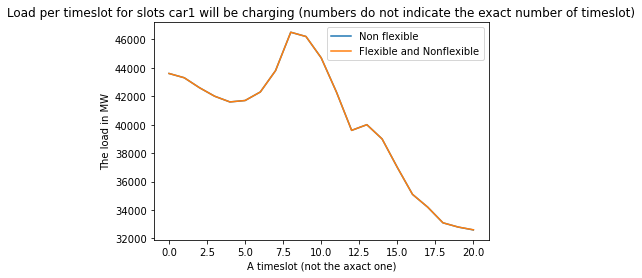

In [13]:
plt.plot(range(len(Non_Flexible_Load('2019/06/01', 1))),Non_Flexible_Load('2019/06/01', 1),label='Non flexible')
plt.plot(range(len(Non_Flexible_Load('2019/06/01', 1))),(Flexible_Load1 + Non_Flexible_Load('2019/06/01', 1)),\
         label='Flexible and Nonflexible')
plt.legend()
plt.title('Load per timeslot for slots car1 will be charging (numbers do not indicate the exact number of timeslot)')
plt.xlabel('A timeslot (not the axact one)')
plt.ylabel('The load in MW')
plt.show()

 **Observations:**

we note three main things:


*   The sum of values in array of flexible load is twice the energy value this is because of the last constraint in our objective function $\dfrac{e_j}{\delta}$ and $\delta$ in our case is $0.5$ which stands for the timeslots.
*   The waterfilling start filling in the timeslots corresponding to the minimum value of the nonflexible load as indicated in plots.
* The two plots lies on top of each other meaning that charging one car won't affect the overall load 

the way the individual EV charging decision be taken into account in the global CO2 emissions minimization pb? well, the decision of one electric vehicle will not really matter golbally it can charge any time as the energy needed is very small compared to actual nonflexible load.



# Define CO2 function:

In [14]:
#assets=[wind, solar, hydro, bio, nuc, gas, coal, fuel]
cost = [0,0,0,0,30,70,86,162] # we order according to cost
CO2_rate = [0,0,0,494,0,429,986,777] # then according to rate 
Cumulative_Production =[0, 5729.7, 8452.1, 33956.1, 36190.1, 97560.1, 110312.1,112130.1]

In [15]:
def CO2_fun(x):
  v=0
  for i in range(len(Cumulative_Production)-1):
    v+=0.5 *(CO2_rate[i+1]-CO2_rate[i])*max(x-Cumulative_Production[i], 0)
  return v

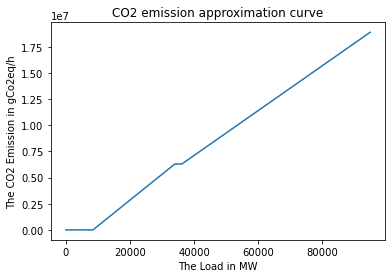

In [16]:
# We try to plot the Co2 Function as in Figure3 in Report (Figure 2 before update)
Load  = np.arange(0,95000,100)
values = []
for i in Load: 
  values.append(CO2_fun(i))

plt.plot(Load,values)
plt.ylabel('The CO2 Emission in gCo2eq/h')
plt.xlabel('The Load in MW')
plt.title('CO2 emission approximation curve')
plt.show()

**Understanding the CO2 Function:**

The function Works in the following manner you have some energy to satisfy so you will use some assets for this regard you first start with the cheapest then with the assets with less emissions you see how much of load you can cover with these assets and then you move to the next ones to completely provide the specific amount of energy, and you check the overall emission resulted from this load.

For instance you have an $x$ MW amount, you see how much you can provide from wind and solar (they have zero emission) then you move to hydro then you go back to nuclear with zero emission so the emission resulted from hydro will be constant then moving to the other assets emission increase "Note that hydro in table has negative value we guess that the reason lies on the fact when you subtract in the CO2 function nuclear from hudro you will have negative value so this negative was put to make it positive otherwise emission will decrease."

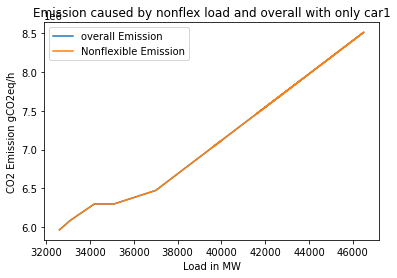

In [17]:
#Check the CO2 emission with and without the load of one EV.
values = []
for t in range(len(Flexible_Load1)):
  u = CO2_fun(Non_Flexible_Load('2019/06/01', 1)[t]+Flexible_Load1[t]) #emissions at timeslot t for the overall load
  values.append(u)
plt.plot((Non_Flexible_Load('2019/06/01', 1)+Flexible_Load1), values,label = 'overall Emission')

values = []
for t in range(len(Flexible_Load1)):
  u = CO2_fun(Non_Flexible_Load('2019/06/01', 1)[t]) #emissions at timeslot t for the nonflexible load only
  values.append(u)
plt.plot((Non_Flexible_Load('2019/06/01', 1)), values,label = 'Nonflexible Emission')
plt.title('Emission caused by nonflex load and overall with only car1')
plt.xlabel('Load in MW')
plt.ylabel('CO2 Emission gCO2eq/h')
plt.legend()
plt.show()

**Observation:**

The CO2 emissions are not affected by the charging of one electrical Vehicle, with the above plot we see for every load its corresponding emission.

_________________________________________________________________________________

# Decentralized Mechanism to solve the objective function Using Best Response Dynamics:


Now moving to the Game Theory Part (it is afterall a TP game theory)

A mechanism to solve this Objective function will be the algorithm best response dynamics and to be particular the version of it we will be using here is the ***Asynchronous Best-Reply Dynamics*** which is a version of the BRD used in resource allocation where players are playing simultaneously and independently without anyone controling this whole process, each player playing in a best response manner for picking the best timeslots, this is Indeed a ***congestion game*** where resources are the time slots and the player want to allocate the charging in the best time slot in accordance to all the loads of others and not to forget the non-flexible, since it is a congestion game we can find a potential function implying that it is an exact potential game and we know that Pure Nash equilibrium exists, and best response dynamics ***converge to a pure nash equilibrium*** in exact potential games and its worth mentioning that it has fast convergence, so we are definite that our objective function can be solved in the line of game theory to a nash equilibrium in wish no player will have an incentive to deviate from his solution.

In [18]:
# The following code snippet was inspired by our colleague Richard Willouw 
def bestresponsedynamics(date, eta, Kmax, delta):
  arrival_records = []  # internally we will define a common interval for all players
  departure_records = []
  for i in range(10):
    arrival_records.append(arrival_time(date, i+1))
    departure_records.append(Departure_time(date,i+1))

  l_prev = np.zeros((10,len(Non_Flexible_Load(date, 1, min(arrival_records), max(departure_records) ))))
  l_next = np.ones((10,len(Non_Flexible_Load(date, 1, min(arrival_records), max(departure_records) ))))

  k = 0
  nonflexible = Non_Flexible_Load(date, 1, min(arrival_records), max(departure_records)) # as flexible will 
    #be the same for all ID
  while k <= Kmax and np.linalg.norm(l_next - l_prev) >= eta: # The seconds norm was the stopping criteria & iterations
    k += 1
    l_prev = l_next
    for i in range(10):
      l_next[i,:] =  waterfilling((nonflexible+l_next.sum(axis = 0) - l_next[i,:]), 0.5 , Energy_need(date, i+1))
    '''
    you sum all the flexible load of all other players except you and since you update in same loop 
    we are considering the updates for previous players and the unupdates for the others
    '''
  return l_next , nonflexible # to obtain the common nonflexible as well  for plots


In [19]:
l,b = bestresponsedynamics( '2019/06/01', 0.0000000000001, 10e12, 0.5)
print(l)

[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  2.95  7.05 ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  2.95  7.05 ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    4.064 7.112
  7.112 7.112]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  2.95  7.05 ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.84
  7.04  7.04 ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  2.95  7.05 ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0. 

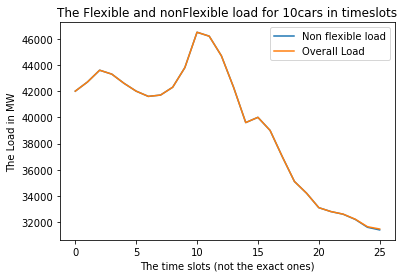

In [20]:
Flexible_profile , nonflexible_profile = bestresponsedynamics( '2019/06/01', 0.0000000000001, 10e12, 0.5)
All_profiles = np.sum(Flexible_profile, axis = 0) + nonflexible_profile
plt.plot(range(len(nonflexible_profile)),nonflexible_profile,label='Non flexible load')
plt.plot(range(len(nonflexible_profile)),(All_profiles),label='Overall Load')
plt.legend()
plt.title('The Flexible and nonFlexible load for 10cars in timeslots')
plt.xlabel('The time slots (not the exact ones)')
plt.ylabel('The Load in MW')
plt.show()

the values for all CO2 emissions are: [7545711.550000001, 7695861.550000001, 7888911.550000001, 7824561.550000001, 7674411.550000001, 7545711.550000001, 7459911.550000001, 7481361.550000001, 7610061.550000001, 7931811.550000001, 8510961.55, 8446611.55, 8124861.550000001, 7610061.550000001, 7030911.550000001, 7116711.550000001, 6902211.550000001, 6473211.550000001, 6299488.0, 6299488.0, 6088031.300000001, 6013931.300000001, 5966088.881999999, 5869691.204, 5728377.563999999, 5685557.643999999]
The values for nonflex CO2 emissons are: [7545711.550000001, 7695861.550000001, 7888911.550000001, 7824561.550000001, 7674411.550000001, 7545711.550000001, 7459911.550000001, 7481361.550000001, 7610061.550000001, 7931811.550000001, 8510961.55, 8446611.55, 8124861.550000001, 7610061.550000001, 7030911.550000001, 7116711.550000001, 6902211.550000001, 6473211.550000001, 6299488.0, 6299488.0, 6088031.300000001, 6013931.300000001, 5964531.300000001, 5865731.300000001, 5717531.300000001, 5668131.30000000

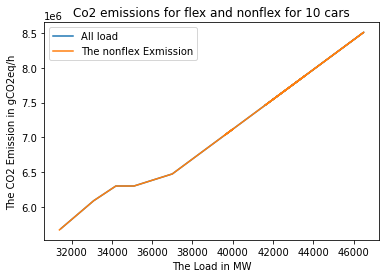

In [21]:
values = []
for t in range(len(nonflexible_profile)):
  u = CO2_fun(All_profiles[t])
  values.append(u)
print('the values for all CO2 emissions are:',values)
plt.plot(All_profiles,(values),label='All load')

values1 = []
for t in range(len(nonflexible_profile)):
  u = CO2_fun(nonflexible_profile[t])
  values1.append(u)
print('The values for nonflex CO2 emissons are:',values1)
plt.plot(nonflexible_profile,((values1)), label = 'The nonflex Exmission')
plt.xlabel('The Load in MW')
plt.ylabel('The CO2 Emission in gCO2eq/h')
plt.title('Co2 emissions for flex and nonflex for 10 cars')
plt.legend()
plt.show()

**Observations:**

From all the previous plots tested in the date: 2019/06/01 we can see:


*   From Flex and non Flex load for 10cars we see a tiny difference 10 cars can make over the overall load and this difference takes place on where the waterfilling will fill the energy.
*   On the Co2 emissions 10 cars is not a much.
*   From the values of emission in case of nonflex load and all loads we see a small increase in values in the end of around 20000 gCO2eq/h





---



---



---



# Some Experiments:

Now that we have a running functions and observed the affect of 1 and 10 we wanted to run an experiment but with a larger data, so we have considered all the 10 cars as one car so for every day we have 1 car that is treated instead of the others, with the maximum of each arrival among them and the minimum of departure and the sum of enerrgy, so we had a profile of 30 cars with an energy need and arrival departure, then we took the average of the non flexible load within the arrival departure interval over all the day in the month.

but we fall under the problem of capacity because it is supposed to be 5, to escape this we have made a slight increase roughly 20 KWH and peeformed the comparisons

## Helpful Functions for comparisons.

In [22]:
def get_average_nonflex(T, date, year, month): # gives energy need and average nonflex
  arrival = []
  departure = []
  energy = []
  max_arrival = []
  min_departure = []
  for i in T: 
    count = 0
    for j in range(10):
      max_arrival.append(arrival_time(i,j+1))
      min_departure.append(Departure_time(i,j+1))
      count += Energy_need(i,j+1)
    energy.append(count)
    arrival.append(max(max_arrival))
    departure.append(min(min_departure))
  hours , minutes, seconds = min(arrival).hour , min(arrival).minute , min(arrival).second
  hours1 , minutes1, seconds1 = max(departure).hour , max(departure).minute , max(departure).second

  avg_nonflex = [0]*len(Non_Flexible_Load(date, month, datetime(year,month,4,hours,minutes,seconds).strftime('%Y/%m/%d %H:%M:%S'),datetime(year,month,5,hours1,minutes1,seconds1).strftime('%Y/%m/%d %H:%M:%S')))
  for i in T:
    u = datetime.strptime(i,'%Y/%m/%d').day
    v = Non_Flexible_Load(i, month, datetime(year,month,u,hours,minutes,seconds).strftime('%Y/%m/%d %H:%M:%S'),datetime(year,month,u+1,hours1,minutes1,seconds1).strftime('%Y/%m/%d %H:%M:%S'))
    avg_nonflex = np.add(avg_nonflex,v)
  avg_nonflex /= 31
  return avg_nonflex , energy

def waterfilling_capacity(nonflexible_load,  delta , energy,c): # a function for waterfilling with capacities
  k = 0
  kmax = 1000
  epsilon = min(np.min(nonflexible_load), energy) / 100  # a proper epsilon for stopping criteria and filling
  flexible_load = np.zeros(len(nonflexible_load))
  while k < kmax and  abs(np.sum(flexible_load) - energy/delta ) > epsilon:
    k += 1
    non_saturated = []
    minimal_current = []
    for i in range(len(nonflexible_load)):
      if flexible_load[i] < c:
        non_saturated.append(i)
    minimal_current = np.min(nonflexible_load[non_saturated] + flexible_load[non_saturated])
    for t in non_saturated:
      if nonflexible_load[t] + flexible_load[t] == minimal_current :
        flexible_load[t] += epsilon # the way you will fill 
    
  return flexible_load

def bestresponsedynamics_withminmax(avg_nonflex,energy, eta, Kmax, delta,C):# the bestresponse for a given interval
  l_prev = np.zeros((len(energy),len(avg_nonflex)))
  l_next = np.ones((len(energy),len(avg_nonflex)))

  k = 0
  while k <= Kmax and np.linalg.norm(l_next - l_prev) >= eta:
    k += 1
    l_prev = l_next
    for i in range(len(energy)):
      l_next[i,:] =  waterfilling_capacity((avg_nonflex +l_next.sum(axis = 0) - l_next[i,:]), 0.5 , energy[i],C)
  return l_next 

## Get unique dates in a list

In [23]:
# define a function to return unique values: 
def get_unique_numbers(numbers):

    list_of_unique_numbers = []

    unique_numbers = set(numbers)

    for number in unique_numbers:
        list_of_unique_numbers.append(number)

    return list_of_unique_numbers

## Comparing winter season over 2019, 2020

In [24]:
# choosing the winter 2019 season: 
dates = []
for i in data2019['day']:
  if i.month == 1:
    dates.append(i.strftime('%Y/%m/%d'))
  else:
    continue 
#The dates array and removing the last day in the month as no data available for it.
dates = get_unique_numbers(dates)
dates.remove('2019/01/31')
T = dates
# choosing the winter 2020 season: 
dates = []
for i in data2020['day']:
  if i.month == 1:
    dates.append(i.strftime('%Y/%m/%d'))
  else:
    continue 
#The dates array and removing the last day in the month as no data available for it.
#I mean the next day will be no data for it.
dates = get_unique_numbers(dates)
dates.remove('2020/01/31')
B = dates

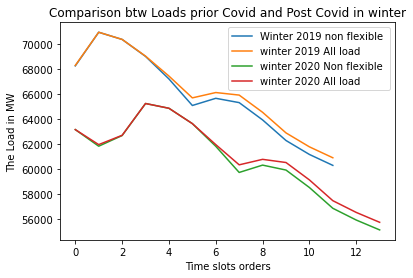

In [25]:
# For winter 2019 season
avg_nonflex, energy = get_average_nonflex(T, '2019/01/01', 2019,1)
allwinter = bestresponsedynamics_withminmax(avg_nonflex,energy, 0.004, 10, 0.5,20)
plt.plot(range(len(avg_nonflex)),avg_nonflex,label='Winter 2019 non flexible')
plt.plot(range(len(avg_nonflex)),(avg_nonflex + np.sum(allwinter,axis = 0)),label='winter 2019 All load')

#For winter 2020 season
avg_nonflexwin2020, energywin2020 = get_average_nonflex(B, '2020/01/01', 2020,1)
allwinter2020 = bestresponsedynamics_withminmax(avg_nonflexwin2020,energywin2020, 0.004, 10, 0.5,20)
plt.plot(range(len(avg_nonflexwin2020)),avg_nonflexwin2020,label='winter 2020 Non flexible ')
plt.plot(range(len(avg_nonflexwin2020)),(avg_nonflexwin2020 + np.sum(allwinter2020,axis = 0)),label='winter 2020 All load')

plt.legend()
plt.xlabel('Time slots orders')
plt.ylabel('The Load in MW')
plt.title('Comparison btw Loads prior Covid and Post Covid in winter')
plt.show()

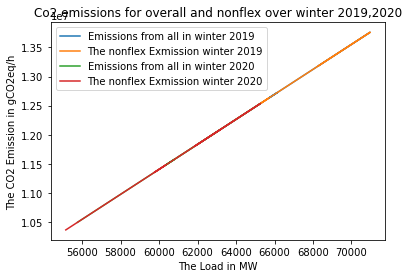

In [26]:
#CO2 Emissions Over winter 2019
Allloadwinter2019 = avg_nonflex + np.sum(allwinter,axis = 0)
values = []
for t in range(len(avg_nonflex)):
  u = CO2_fun(Allloadwinter2019[t])
  values.append(u)
plt.plot(Allloadwinter2019,(values),label='Emissions from all in winter 2019')

values1 = []
for t in range(len(avg_nonflex)):
  u = CO2_fun(avg_nonflex[t])
  values1.append(u)
plt.plot(avg_nonflex,((values1)), label = 'The nonflex Exmission winter 2019')

#CO2 emissions over winter 2020
Allloadwinter2020 = avg_nonflexwin2020 + np.sum(allwinter2020,axis = 0)
values = []
for t in range(len(avg_nonflexwin2020)):
  u = CO2_fun(Allloadwinter2020[t])
  values.append(u)
plt.plot(Allloadwinter2020,(values),label='Emissions from all in winter 2020')

values1 = []
for t in range(len(avg_nonflexwin2020)):
  u = CO2_fun(avg_nonflexwin2020[t])
  values1.append(u)
plt.plot(avg_nonflexwin2020,((values1)), label = 'The nonflex Exmission winter 2020')
plt.xlabel('The Load in MW')
plt.ylabel('The CO2 Emission in gCO2eq/h')
plt.title('Co2 emissions for overall and nonflex over winter 2019,2020')
plt.legend()
plt.show()

## Comparing summer season over 2019, 2020

In [27]:
# choosing the summer 2019 season: 
dates = []
for i in data2019['day']:
  if i.month == 6:
    dates.append(i.strftime('%Y/%m/%d'))
  else:
    continue 
#The dates array and removing the last day in the month as no data available for it.
dates = get_unique_numbers(dates)
dates.remove('2019/06/30')
Q = dates
# choosing the summer 2020 season: 
dates = []
for i in data2020['day']:
  if i.month == 6:
    dates.append(i.strftime('%Y/%m/%d'))
  else:
    continue 
#The dates array and removing the last day in the month as no data available for it.
dates = get_unique_numbers(dates)
dates.remove('2020/06/30')
A = dates

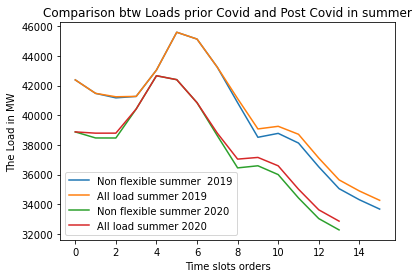

In [28]:
# Same for summer 2019
avg_nonflexsum2019, energy = get_average_nonflex(Q, '2019/06/01', 2019,6)
allsummer2019 = bestresponsedynamics_withminmax(avg_nonflexsum2019,energy, 0.004, 10, 0.5,20)
plt.plot(range(len(avg_nonflexsum2019)),avg_nonflexsum2019,label='Non flexible summer  2019')
plt.plot(range(len(avg_nonflexsum2019)),(avg_nonflexsum2019 + np.sum(allsummer2019,axis = 0)),label='All load summer 2019')
#Summer 2020
avg_nonflexsum2020, energy = get_average_nonflex(A, '2020/06/01', 2020,6)
allsummer2020 = bestresponsedynamics_withminmax(avg_nonflexsum2020,energy, 0.004, 10, 0.5,20)
plt.plot(range(len(avg_nonflexsum2020)),avg_nonflexsum2020,label='Non flexible summer 2020')
plt.plot(range(len(avg_nonflexsum2020)),(avg_nonflexsum2020 + np.sum(allsummer2020,axis = 0)),label='All load summer 2020')

plt.legend()
plt.xlabel('Time slots orders')
plt.ylabel('The Load in MW')
plt.title('Comparison btw Loads prior Covid and Post Covid in summer')
plt.show()


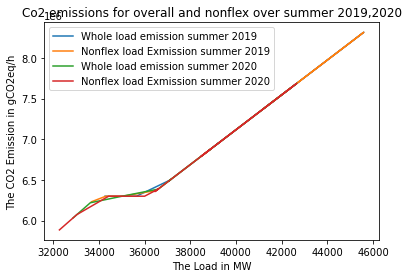

In [29]:
#CO2 emission for summer 2019
Allloadsummer2019 = avg_nonflexsum2019 + np.sum(allsummer2019,axis = 0)
values = []
for t in range(len(avg_nonflexsum2019)):
  u = CO2_fun(Allloadsummer2019[t])
  values.append(u)
plt.plot(Allloadsummer2019,(values),label='Whole load emission summer 2019')

values1 = []
for t in range(len(avg_nonflexsum2019)):
  u = CO2_fun(avg_nonflexsum2019[t])
  values1.append(u)
plt.plot(avg_nonflexsum2019,((values1)), label = 'Nonflex load Exmission summer 2019')


#CO2 emission for summer 2020
Alloadsummer2020 = avg_nonflexsum2020 + np.sum(allsummer2020,axis = 0)
values = []
for t in range(len(avg_nonflexsum2020)):
  u = CO2_fun(Alloadsummer2020[t])
  values.append(u)
plt.plot(Alloadsummer2020,(values),label='Whole load emission summer 2020')

values1 = []
for t in range(len(avg_nonflexsum2020)):
  u = CO2_fun(avg_nonflexsum2020[t])
  values1.append(u)
plt.plot(avg_nonflexsum2020,((values1)), label = 'Nonflex load Exmission summer 2020')
plt.xlabel('The Load in MW')
plt.ylabel('The CO2 Emission in gCO2eq/h')
plt.title('Co2 emissions for overall and nonflex over summer 2019,2020')
plt.legend()
plt.show()

## Comparing Winter vs Summer in 2019

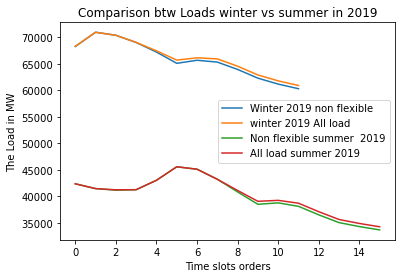

In [30]:
plt.plot(range(len(avg_nonflex)),avg_nonflex,label='Winter 2019 non flexible')
plt.plot(range(len(avg_nonflex)),(avg_nonflex + np.sum(allwinter,axis = 0)),label='winter 2019 All load')
plt.plot(range(len(avg_nonflexsum2019)),avg_nonflexsum2019,label='Non flexible summer  2019')
plt.plot(range(len(avg_nonflexsum2019)),(avg_nonflexsum2019 + np.sum(allsummer2019,axis = 0)),label='All load summer 2019')

plt.legend()
plt.xlabel('Time slots orders')
plt.ylabel('The Load in MW')
plt.title('Comparison btw Loads winter vs summer in 2019')
plt.show()



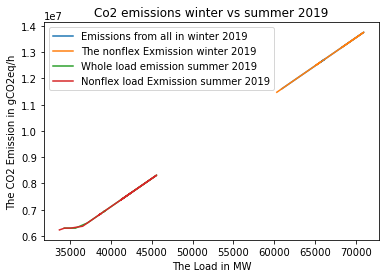

In [31]:
#CO2 Emissions Over winter 2019
Allloadwinter2019 = avg_nonflex + np.sum(allwinter,axis = 0)
values = []
for t in range(len(avg_nonflex)):
  u = CO2_fun(Allloadwinter2019[t])
  values.append(u)
plt.plot(Allloadwinter2019,(values),label='Emissions from all in winter 2019')

values1 = []
for t in range(len(avg_nonflex)):
  u = CO2_fun(avg_nonflex[t])
  values1.append(u)
plt.plot(avg_nonflex,((values1)), label = 'The nonflex Exmission winter 2019')

#CO2 emission for summer 2019
Allloadsummer2019 = avg_nonflexsum2019 + np.sum(allsummer2019,axis = 0)
values = []
for t in range(len(avg_nonflexsum2019)):
  u = CO2_fun(Allloadsummer2019[t])
  values.append(u)
plt.plot(Allloadsummer2019,(values),label='Whole load emission summer 2019')

values1 = []
for t in range(len(avg_nonflexsum2019)):
  u = CO2_fun(avg_nonflexsum2019[t])
  values1.append(u)
plt.plot(avg_nonflexsum2019,((values1)), label = 'Nonflex load Exmission summer 2019')

plt.xlabel('The Load in MW')
plt.ylabel('The CO2 Emission in gCO2eq/h')
plt.title('Co2 emissions winter vs summer 2019')
plt.legend()
plt.show()

**Observations:**

We see how the load in winter is way greater than summer and this causes a higher CO2 emissions, maybe because of heaters dryer machines and many others making the nonflex load higher and also how the flex load affected the overall load by increasing it just for 30 big cars you can imagine how it will be for 20M vehicles to go, post corona has hugely affected the overall load, the load decreased a lot, because we had few cars and all the cars filled in the same slot we saw a tiny increase, but this is a drawback to the decentralized mechanism.



---



---



---



## **TO Conclude**:

Unfortunately we could not implement the charging policies to give our input on them, but at least for the plug and charge we believe it will highly increase the emissions if maybe they coincided with a peak of CO2 emissions.
and unfortunately our code was constructed on dealing with arrival departure as timedate variable not timeslot which we think will be easier to deal with as you fill with maximmum capacity at slot aj+1. we think off peak will give a better solution.

Centralized mechanism as the name suggets having a control over all the charging process (like a mediator) will enhance the overall CO2 emission and I guess it will give a more enhanced Nash equilibrium since you applied cooperation.

Unfortunatley, using a modeler like pyomo to solve the 1EV problem has not been applied, but the waterfilling will give a better more enhanced solution to bee feeded to the best response and perform the decentralized mechanism.

***side Note:***

we did not apply The Linearized model of the objective function with pyomo mentioned in the appendix as we unfortunatley thought equation five is enough as an objective function and that waterfilling will give a better performance for each car.